<a href="https://colab.research.google.com/github/TitasBal/The_fifth_column/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install "torch == 2.2.1"

In [89]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [90]:
import torch
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [91]:
!pip install pandas

In [92]:
import pandas as pd
df = pd.read_csv('komentarai.csv', encoding='utf-8')
df.head()

,Id,User,Comment,Flag
0,1,Þilvinas Ramonas,Kada ateis toki valdze kai tuos kenkejus gales...,1
1,2,Regina Sakalauskienë,Lietuvoje teisësaugos nëra- viskà lemia piniga...,1
2,3,Alma Kecioglu,Net liüdna kad Lt gelezine diktatüra ir baisu ...,1
3,4,Zilvinas Zilvinas,"Suklastojo paraðus,klastos rinkimus,kitaip kon...",1
4,5,Arnoldas Plus,Iðvaizda iðduoda kad Ingrid Ðymon nëra lietuvë...,1


In [93]:
# Čia yra galimybė įdėti language detect naudojant spacy, kai duomenų rinkinyje bus daugiau kalbų.

In [94]:
dict(df.groupby('Flag').count()['Id'])

{0: 443, 1: 568}

In [95]:
# text processing function

import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove next line
    text = re.sub(r'[^ \w\.]', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    return text
# Create a new column called "Text" for collecting clean text
df['Text'] = df.Comment.apply(lambda x: clean_text(x))

In [96]:
df.Text.values[0]

'kada ateis toki valdze kai tuos kenkejus gales susodint i kaliuze su turta konfiskavimu  turbut niekada'

In [97]:
# install transformers
!pip install "transformers ==4.40.2"

In [98]:
!pip install "sentencepiece==0.2.0"

In [99]:
force_download=True

In [100]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('EMBEDDIA/litlat-bert')
# Add words into token
tokenizer.add_tokens(['lansberginiai', 'valdžia', 'nuversti'])

3

In [101]:
print(tokenizer.tokenize('lansberginiai'))
print(tokenizer.tokenize('valdžia'))
print(tokenizer.tokenize('nuversti'))

['lansberginiai']
['valdžia']
['nuversti']


In [102]:
df.Text.values[0]

'kada ateis toki valdze kai tuos kenkejus gales susodint i kaliuze su turta konfiskavimu  turbut niekada'

In [103]:
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.Text.values[0].split()})

{'kada': [2579], 'ateis': [20625], 'toki': [28740], 'valdze': [1398, 1810], 'kai': [226], 'tuos': [3814], 'kenkejus': [27539, 25341], 'gales': [564, 61], 'susodint': [2111, 406, 818], 'i': [513], 'kaliuze': [1640, 224, 1810], 'su': [48], 'turta': [520, 166], 'konfiskavimu': [34432, 6379], 'turbut': [41101], 'niekada': [3941]}


In [104]:
tokenizer(df.Text.values[0])['input_ids']

[0,
 2579,
 20625,
 28740,
 1398,
 1810,
 226,
 3814,
 27539,
 25341,
 564,
 61,
 2111,
 406,
 818,
 513,
 1640,
 224,
 1810,
 48,
 520,
 166,
 34432,
 6379,
 41101,
 3941,
 2]

max:  570
min:  3


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600'),
  Text(0, 700.0, '700'),
  Text(0, 800.0, '800'),
  Text(0, 900.0, '900')])

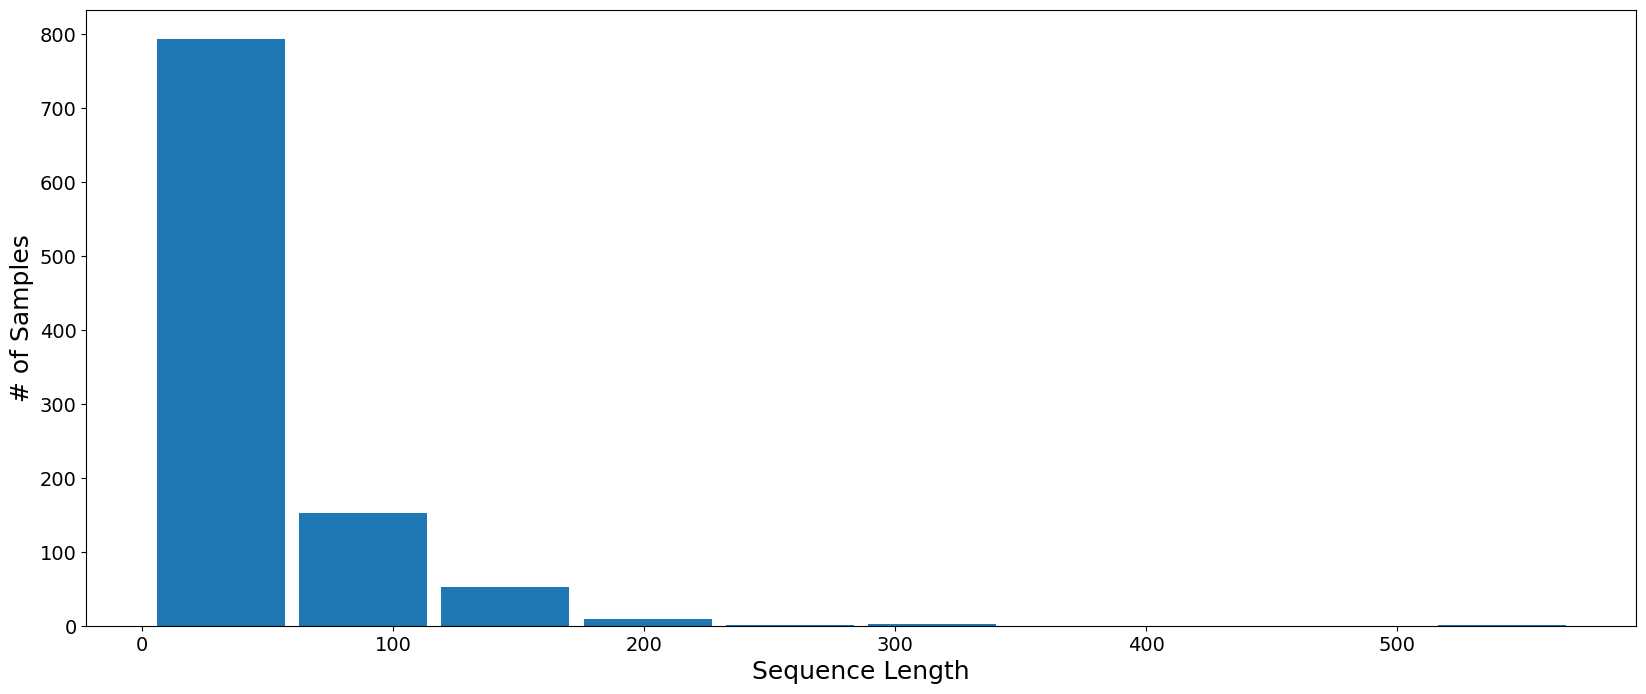

In [105]:
# install matplotlib
!pip install matplotlib
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            df.Text.values.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [106]:
# identify features and target
features = df.Text.values.tolist()
target = df.Flag.values.tolist()

In [107]:
# tokenize features
MAX_LEN = 491
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features,
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN,
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'
                   )

In [108]:
# install sklearn
!pip install scikit-learn
# convert label into numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)

In [109]:
target_num

array([1, 1, 1, ..., 0, 0, 0])

In [110]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(tokenized_feature['input_ids'],
                                                                                                             target_num,
                                                                                                                    tokenized_feature['attention_mask'],
                                                                                                      random_state=2018, test_size=0.2, stratify=target)

In [111]:
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [112]:
force_download=True

In [113]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "EMBEDDIA/litlat-bert",
    # Specify number of classes
    num_labels = len(set(target)),
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states
    output_hidden_states = False
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/litlat-bert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
model.resize_token_embeddings(len(tokenizer))

Embedding(84201, 768, padding_idx=1)

In [115]:
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [116]:
# Number of training epochs
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [117]:
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(84201, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

In [118]:

import time
# Store the average loss after each epoch
loss_values = []
# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)
# looping over epochs
for epoch_i in range(0, epochs):

    print('training on epoch: ', epoch_i)
    # set start time
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training
    model.train()
    # loop through batch
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        # load data from dataloader
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # clear any previously calculated gradients
        model.zero_grad()
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # get loss
        loss = outputs[0]
        # total loss
        total_loss += loss.item()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update optimizer
        optimizer.step()
        # update learning rate
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  3.1875
training on epoch:  0
training on step:  50
total time used is: 130.64 s
average training loss: 0.70
training on epoch:  1
training on step:  50
total time used is: 130.68 s
average training loss: 0.70
training on epoch:  2
training on step:  50
total time used is: 133.54 s
average training loss: 0.70
training on epoch:  3
training on step:  50
total time used is: 129.64 s
average training loss: 0.70


In [119]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)

print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 11.55 s


In [120]:
predictions

[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]),
 array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]),
 array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])]

In [121]:
# convert numeric label to string
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

In [122]:
final_prediction_list

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1])

In [123]:
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(final_truelabel_list,
                           final_prediction_list,
                           output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.43      0.74      0.55        89
           1       0.54      0.24      0.33       114

    accuracy                           0.46       203
   macro avg       0.49      0.49      0.44       203
weighted avg       0.49      0.46      0.42       203



Text(95.72222222222221, 0.5, 'Predicted Sentiment Label')

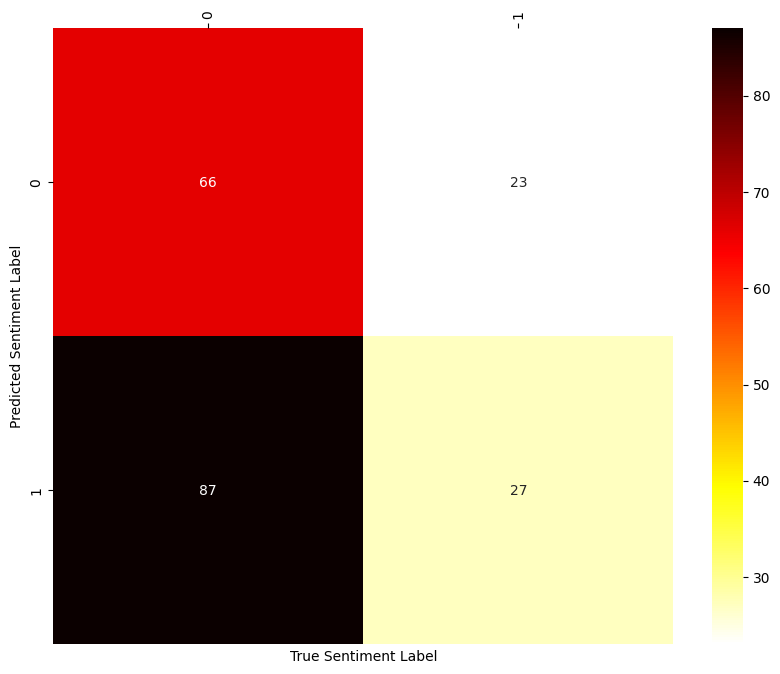

In [124]:
# install seaborn
!pip install seaborn
# print cm heatmap
import seaborn as sns
# return class label
class_label = np.unique(final_truelabel_list)
# get confusion matrix
cm = confusion_matrix(final_truelabel_list,
                      final_prediction_list)
# covert it to dataframe for plotting
cm_df = pd.DataFrame(cm,
                     index = class_label,
                     columns = class_label)
# plot it
plt.figure(figsize = (10,8))
g = sns.heatmap(cm_df, cmap = 'hot_r', annot=True, fmt='g')
g.xaxis.set_ticks_position("top")
g.tick_params(axis='x', rotation=90)
g.set_xlabel("True Sentiment Label")
g.set_ylabel("Predicted Sentiment Label")